In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torchvision.ops
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
raw_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
train_dir=raw_image_dir

In [4]:
train_fns = os.listdir(raw_image_dir)
val_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10")
print(len(train_fns), len(val_fns))

8000 234


In [5]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

transform = T.Resize(size = (512,512))


C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100\00000_FV.png


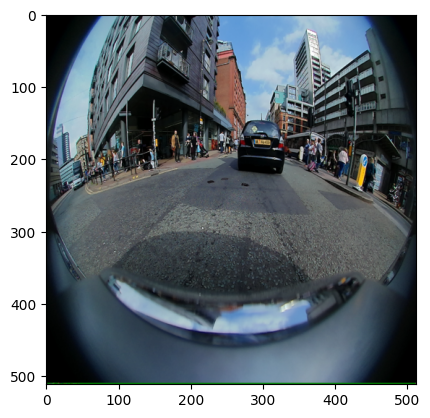

In [6]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = transform(Image.open(sample_image_fp)).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [7]:
train_label_fns = os.listdir(label_image_dir)
val_label_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10")
print(len(train_label_fns), len(val_label_fns))

8000 234


C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100\00002_FV.png


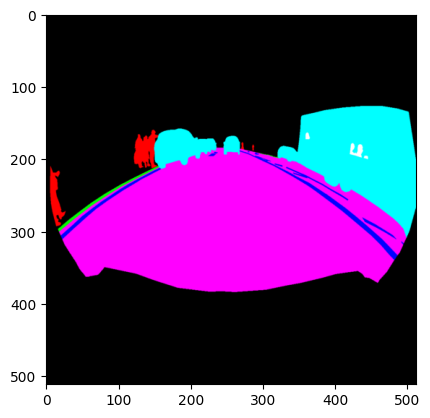

In [8]:
sample_label_fp = os.path.join(label_image_dir, train_label_fns[2])
sample_label = transform(Image.open(sample_label_fp)).convert("RGB")
plt.imshow(sample_label)
print(sample_label_fp)

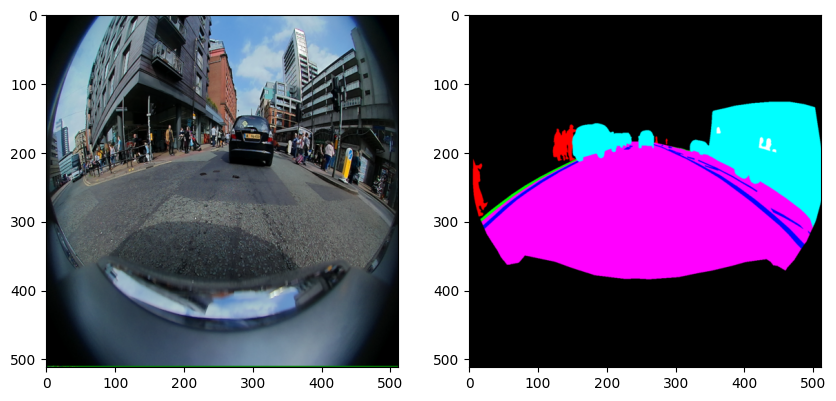

In [9]:

woodscape, label = Image.fromarray(np.array(sample_image)), Image.fromarray(np.array(sample_label))
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)

In [10]:
num_items = 1000
color_array = np.random.choice(range(512), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [11]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

C:\Users\yashs\Woodscape\woodscape_cuda_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [12]:
sample_label = label.convert("RGB")

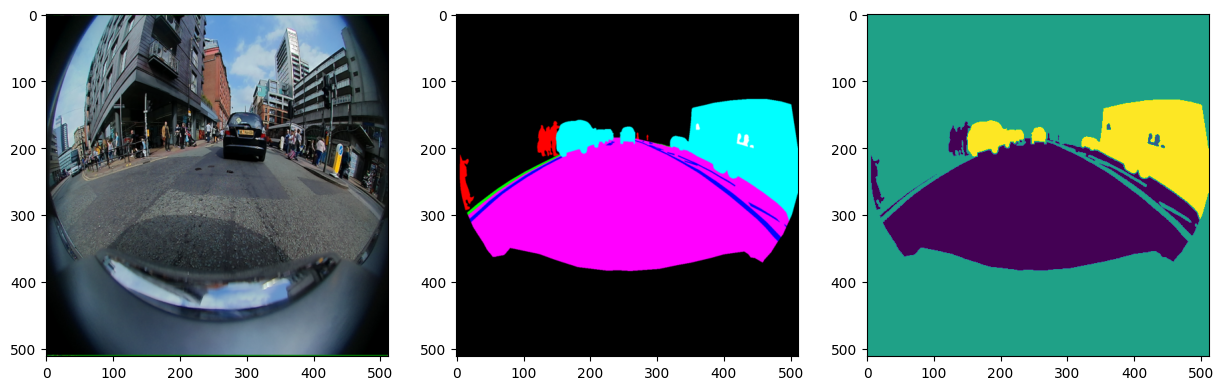

In [13]:
woodscape, label = np.array(sample_image),np.array(sample_label)
label_class = label_model.predict(label.reshape(-1,3)).reshape(512,512)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [14]:
label_class

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]])

In [15]:
class WoodscapeDataset(Dataset):

  def __init__(self, image_dir, label_dir, label_model):
    self.image_dir = image_dir
    self.label_dir = label_dir
    self.image_fns = os.listdir(image_dir)
    self.label_fns = os.listdir(label_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    label_fn = self.label_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    label_fp = os.path.join(self.label_dir, label_fn)
    image = transform(Image.open(image_fp)).convert("RGB")
    label = transform(Image.open(label_fp)).convert("RGB")
    image = np.array(image)
    woodscape = np.array(image)
    label = np.array(label)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(512,512)
    label_class = torch.Tensor(label_class).long()
    woodscape = self.transform(woodscape)
    return woodscape, label_class
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [16]:
train_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
print(len(dataset))

8000


In [17]:
woodscape, label_class = dataset[0]
print(woodscape.shape, label_class.shape)

torch.Size([3, 512, 512]) torch.Size([512, 512])


In [19]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle=self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [20]:
model = UNet(num_classes=num_classes)

In [21]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).__next__()
print(X.shape, Y.shape)

8000 2000
torch.Size([4, 3, 512, 512]) torch.Size([4, 512, 512])


In [22]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 512, 512])


In [23]:
batch_size = 1
epochs = 20
lr = 0.00001
weight_decay=0.001

In [24]:
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [25]:
model = UNet(num_classes = num_classes).to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr,weight_decay=weight_decay)

In [27]:
import time
step_losses = []
epoch_losses = []

total_start = time.time()
for epoch in tqdm(range(epochs)):
    epoch_start = time.time()
    print("--------------------- Epoch number: "+str(epoch)+" ---------------------------------")
    epoch_loss = 0
    counter = 0
    for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
        counter=counter+1
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        if counter%500==0:
            print("step number",counter)
            print("epoch_loss : ",epoch_loss)
            print("step_losses : ",loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))
    epoch_end = time.time()
    print("Epoch Time Taken",epoch_end - epoch_start)
total_end = time.time()
print("Total Time Taken",total_end - total_start)

  0%|          | 0/20 [00:00<?, ?it/s]

--------------------- Epoch number: 0 ---------------------------------


  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  717.1764889955521
step_losses :  1.341827630996704
step number 1000
epoch_loss :  1081.9688482880592
step_losses :  0.4062662124633789
step number 1500
epoch_loss :  1325.8636257201433
step_losses :  0.4765014946460724
step number 2000
epoch_loss :  1563.7465329170227
step_losses :  1.0321567058563232
step number 2500
epoch_loss :  1757.5000073090196
step_losses :  0.26187664270401
step number 3000
epoch_loss :  1968.2661318033934
step_losses :  0.17422634363174438
step number 3500
epoch_loss :  2118.451648183167
step_losses :  0.5641686320304871
step number 4000
epoch_loss :  2316.035720832646
step_losses :  0.2681439518928528
step number 4500
epoch_loss :  2473.1763841435313
step_losses :  0.41605883836746216
step number 5000
epoch_loss :  2633.133825071156
step_losses :  0.15876120328903198
step number 5500
epoch_loss :  2775.7640064954758
step_losses :  0.30446895956993103
step number 6000
epoch_loss :  2901.371779076755
step_losses :  0.15578119456768

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  152.34657654166222
step_losses :  0.7832321524620056
step number 1000
epoch_loss :  290.4251668974757
step_losses :  0.1451006531715393
step number 1500
epoch_loss :  399.28042478859425
step_losses :  0.2694309949874878
step number 2000
epoch_loss :  533.1883703768253
step_losses :  0.4161052405834198
step number 2500
epoch_loss :  636.6414425186813
step_losses :  0.11213863641023636
step number 3000
epoch_loss :  765.3527075387537
step_losses :  0.10660253465175629
step number 3500
epoch_loss :  859.4877254068851
step_losses :  0.5184638500213623
step number 4000
epoch_loss :  1002.3774163760245
step_losses :  0.21667584776878357
step number 4500
epoch_loss :  1108.1467006839812
step_losses :  0.24654105305671692
step number 5000
epoch_loss :  1218.5733591206372
step_losses :  0.11768943071365356
step number 5500
epoch_loss :  1315.4197000227869
step_losses :  0.23171618580818176
step number 6000
epoch_loss :  1403.935825549066
step_losses :  0.1172592490

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  108.53796589747071
step_losses :  0.6534284353256226
step number 1000
epoch_loss :  228.20913564413786
step_losses :  0.13001590967178345
step number 1500
epoch_loss :  318.20798202976584
step_losses :  0.21021431684494019
step number 2000
epoch_loss :  441.87075128406286
step_losses :  0.5423388481140137
step number 2500
epoch_loss :  527.3385034687817
step_losses :  0.08299118280410767
step number 3000
epoch_loss :  630.3290795460343
step_losses :  0.07273994386196136
step number 3500
epoch_loss :  707.5216208212078
step_losses :  0.3193216621875763
step number 4000
epoch_loss :  831.3445173874497
step_losses :  0.21170112490653992
step number 4500
epoch_loss :  920.8720422945917
step_losses :  0.18336783349514008
step number 5000
epoch_loss :  1008.5180722773075
step_losses :  0.07885655760765076
step number 5500
epoch_loss :  1088.311484117061
step_losses :  0.1961400806903839
step number 6000
epoch_loss :  1162.324647795409
step_losses :  0.1032301783

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  89.53903323039412
step_losses :  0.5814952254295349
step number 1000
epoch_loss :  185.68015104532242
step_losses :  0.11087631434202194
step number 1500
epoch_loss :  261.78120961785316
step_losses :  0.13615646958351135
step number 2000
epoch_loss :  369.19459227100015
step_losses :  0.2067301869392395
step number 2500
epoch_loss :  443.2664613407105
step_losses :  0.06877290457487106
step number 3000
epoch_loss :  527.0039846319705
step_losses :  0.057394444942474365
step number 3500
epoch_loss :  595.0217835474759
step_losses :  0.24082189798355103
step number 4000
epoch_loss :  692.9188466537744
step_losses :  0.15028920769691467
step number 4500
epoch_loss :  770.2174861747772
step_losses :  0.1275947540998459
step number 5000
epoch_loss :  845.0100157111883
step_losses :  0.0715811550617218
step number 5500
epoch_loss :  918.1013107262552
step_losses :  0.17362281680107117
step number 6000
epoch_loss :  986.4889892376959
step_losses :  0.10713288187

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  76.30096693336964
step_losses :  0.3572721779346466
step number 1000
epoch_loss :  157.83087489008904
step_losses :  0.10987851023674011
step number 1500
epoch_loss :  223.08031770586967
step_losses :  0.11718401312828064
step number 2000
epoch_loss :  311.39345283061266
step_losses :  0.15041714906692505
step number 2500
epoch_loss :  375.75873444601893
step_losses :  0.05400269106030464
step number 3000
epoch_loss :  453.07955457642674
step_losses :  0.05690154433250427
step number 3500
epoch_loss :  515.1606929861009
step_losses :  0.1997600495815277
step number 4000
epoch_loss :  601.0864070653915
step_losses :  0.16062089800834656
step number 4500
epoch_loss :  669.5544056259096
step_losses :  0.09777364134788513
step number 5000
epoch_loss :  738.460183903575
step_losses :  0.10573422908782959
step number 5500
epoch_loss :  803.9778580851853
step_losses :  0.12744078040122986
step number 6000
epoch_loss :  866.6793409362435
step_losses :  0.101432964

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  71.30349603295326
step_losses :  0.4122088551521301
step number 1000
epoch_loss :  142.5126115027815
step_losses :  0.09865600615739822
step number 1500
epoch_loss :  203.12557370215654
step_losses :  0.0966498851776123
step number 2000
epoch_loss :  279.43280194699764
step_losses :  0.13063907623291016
step number 2500
epoch_loss :  338.814764931798
step_losses :  0.04322199150919914
step number 3000
epoch_loss :  404.3325535915792
step_losses :  0.049962498247623444
step number 3500
epoch_loss :  462.3316130246967
step_losses :  0.1624259501695633
step number 4000
epoch_loss :  540.5603076033294
step_losses :  0.16341713070869446
step number 4500
epoch_loss :  603.3488863036036
step_losses :  0.08732913434505463
step number 5000
epoch_loss :  661.8100530896336
step_losses :  0.07983037829399109
step number 5500
epoch_loss :  719.0362196806818
step_losses :  0.12489651888608932
step number 6000
epoch_loss :  776.7315013352782
step_losses :  0.112999916076

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  65.53422792628407
step_losses :  0.40592432022094727
step number 1000
epoch_loss :  141.1858653575182
step_losses :  0.09560007601976395
step number 1500
epoch_loss :  199.11775516346097
step_losses :  0.10296913236379623
step number 2000
epoch_loss :  272.42442813515663
step_losses :  0.14308220148086548
step number 2500
epoch_loss :  327.85935229994357
step_losses :  0.034151144325733185
step number 3000
epoch_loss :  387.43802698142827
step_losses :  0.04428410157561302
step number 3500
epoch_loss :  442.49829558096826
step_losses :  0.2761386036872864
step number 4000
epoch_loss :  510.7732472587377
step_losses :  0.1337188482284546
step number 4500
epoch_loss :  570.1521839741617
step_losses :  0.07649751007556915
step number 5000
epoch_loss :  623.7386814914644
step_losses :  0.07571586966514587
step number 5500
epoch_loss :  674.9937582239509
step_losses :  0.11623607575893402
step number 6000
epoch_loss :  729.0538092907518
step_losses :  0.0767503

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  58.98556425049901
step_losses :  0.17693735659122467
step number 1000
epoch_loss :  118.22365975938737
step_losses :  0.10893218964338303
step number 1500
epoch_loss :  171.0102924183011
step_losses :  0.08404625952243805
step number 2000
epoch_loss :  238.40914715453982
step_losses :  0.13339641690254211
step number 2500
epoch_loss :  290.22160997614264
step_losses :  0.035983361303806305
step number 3000
epoch_loss :  343.3912895284593
step_losses :  0.04093872755765915
step number 3500
epoch_loss :  393.7037800550461
step_losses :  0.11519820988178253
step number 4000
epoch_loss :  456.38147531449795
step_losses :  0.08764489740133286
step number 4500
epoch_loss :  512.8530939593911
step_losses :  0.06934976577758789
step number 5000
epoch_loss :  563.0515592638403
step_losses :  0.06309915333986282
step number 5500
epoch_loss :  613.1088042221963
step_losses :  0.10368796437978745
step number 6000
epoch_loss :  664.3968420922756
step_losses :  0.084689

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  58.226949226111174
step_losses :  0.12685619294643402
step number 1000
epoch_loss :  116.09536014311016
step_losses :  0.09291641414165497
step number 1500
epoch_loss :  166.04214940592647
step_losses :  0.08219435811042786
step number 2000
epoch_loss :  229.7683290373534
step_losses :  0.11218371987342834
step number 2500
epoch_loss :  279.18713865056634
step_losses :  0.03406759351491928
step number 3000
epoch_loss :  329.97158121690154
step_losses :  0.03988564386963844
step number 3500
epoch_loss :  376.5518478266895
step_losses :  0.1096317246556282
step number 4000
epoch_loss :  432.9811661671847
step_losses :  0.07176583260297775
step number 4500
epoch_loss :  485.19582455046475
step_losses :  0.06540578603744507
step number 5000
epoch_loss :  533.03199567087
step_losses :  0.059047818183898926
step number 5500
epoch_loss :  578.3415409196168
step_losses :  0.10653850436210632
step number 6000
epoch_loss :  626.1110100056976
step_losses :  0.0712288

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  51.53007812425494
step_losses :  0.1296786367893219
step number 1000
epoch_loss :  105.24928112514317
step_losses :  0.09156565368175507
step number 1500
epoch_loss :  153.16070333682
step_losses :  0.06181836128234863
step number 2000
epoch_loss :  213.30335802026093
step_losses :  0.11353078484535217
step number 2500
epoch_loss :  259.31293373554945
step_losses :  0.0321572944521904
step number 3000
epoch_loss :  308.5126395020634
step_losses :  0.03787645325064659
step number 3500
epoch_loss :  352.60454922169447
step_losses :  0.13460396230220795
step number 4000
epoch_loss :  404.1683127246797
step_losses :  0.053281020373106
step number 4500
epoch_loss :  453.22634333744645
step_losses :  0.06125364452600479
step number 5000
epoch_loss :  497.37527382932603
step_losses :  0.06018669158220291
step number 5500
epoch_loss :  539.2985514495522
step_losses :  0.10315734148025513
step number 6000
epoch_loss :  583.8339015562087
step_losses :  0.07968156039

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  47.707712115719914
step_losses :  0.14879782497882843
step number 1000
epoch_loss :  97.01323871687055
step_losses :  0.08861539512872696
step number 1500
epoch_loss :  142.6961006615311
step_losses :  0.0667375773191452
step number 2000
epoch_loss :  197.64518696255982
step_losses :  0.08922824263572693
step number 2500
epoch_loss :  241.8303042985499
step_losses :  0.03154030442237854
step number 3000
epoch_loss :  286.5716481246054
step_losses :  0.03719734773039818
step number 3500
epoch_loss :  327.6735530886799
step_losses :  0.08543230593204498
step number 4000
epoch_loss :  376.5984012335539
step_losses :  0.05865905433893204
step number 4500
epoch_loss :  422.7881771530956
step_losses :  0.05886036530137062
step number 5000
epoch_loss :  465.2488932721317
step_losses :  0.05669993907213211
step number 5500
epoch_loss :  504.349320711568
step_losses :  0.09776338189840317
step number 6000
epoch_loss :  546.1036992315203
step_losses :  0.08189519494

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  45.107415640726686
step_losses :  0.15982744097709656
step number 1000
epoch_loss :  89.98018088005483
step_losses :  0.08201795816421509
step number 1500
epoch_loss :  132.08102314919233
step_losses :  0.051796264946460724
step number 2000
epoch_loss :  182.98085908219218
step_losses :  0.10599444806575775
step number 2500
epoch_loss :  224.0988961867988
step_losses :  0.02635372057557106
step number 3000
epoch_loss :  265.31341969408095
step_losses :  0.03448186814785004
step number 3500
epoch_loss :  304.28444164432585
step_losses :  0.07732456177473068
step number 4000
epoch_loss :  350.7671757340431
step_losses :  0.05496159568428993
step number 4500
epoch_loss :  395.8283746615052
step_losses :  0.06122566759586334
step number 5000
epoch_loss :  437.3862701244652
step_losses :  0.05962207168340683
step number 5500
epoch_loss :  475.29991556704044
step_losses :  0.09149633347988129
step number 6000
epoch_loss :  515.8666071277112
step_losses :  0.0743

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  41.663340350613
step_losses :  0.09375658631324768
step number 1000
epoch_loss :  82.74649386294186
step_losses :  0.07243655622005463
step number 1500
epoch_loss :  122.11064878478646
step_losses :  0.060262974351644516
step number 2000
epoch_loss :  168.14276274107397
step_losses :  0.08601832389831543
step number 2500
epoch_loss :  207.12082667276263
step_losses :  0.02637341618537903
step number 3000
epoch_loss :  247.05665365047753
step_losses :  0.03529324382543564
step number 3500
epoch_loss :  284.63915415480733
step_losses :  0.05277762562036514
step number 4000
epoch_loss :  326.8810013309121
step_losses :  0.046186529099941254
step number 4500
epoch_loss :  367.227115560323
step_losses :  0.05260416492819786
step number 5000
epoch_loss :  406.29325873218477
step_losses :  0.05988609790802002
step number 5500
epoch_loss :  445.6755835413933
step_losses :  0.09363867342472076
step number 6000
epoch_loss :  484.16746138967574
step_losses :  0.06070

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  39.63691680692136
step_losses :  0.09054651856422424
step number 1000
epoch_loss :  78.96739919111133
step_losses :  0.06366398930549622
step number 1500
epoch_loss :  115.7007559183985
step_losses :  0.050184085965156555
step number 2000
epoch_loss :  160.4995039589703
step_losses :  0.0861668586730957
step number 2500
epoch_loss :  197.64360894542187
step_losses :  0.021704254671931267
step number 3000
epoch_loss :  235.64613957423717
step_losses :  0.031838711351156235
step number 3500
epoch_loss :  272.0407850900665
step_losses :  0.06022140011191368
step number 4000
epoch_loss :  312.9412400489673
step_losses :  0.04304245114326477
step number 4500
epoch_loss :  352.1684001041576
step_losses :  0.05308534950017929
step number 5000
epoch_loss :  389.9883273681626
step_losses :  0.0527183823287487
step number 5500
epoch_loss :  426.5016681039706
step_losses :  0.09021034091711044
step number 6000
epoch_loss :  463.0197784444317
step_losses :  0.05746392

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  38.40440273843706
step_losses :  0.07744568586349487
step number 1000
epoch_loss :  76.67843114025891
step_losses :  0.04576238989830017
step number 1500
epoch_loss :  112.68781290017068
step_losses :  0.058864492923021317
step number 2000
epoch_loss :  155.51488377526402
step_losses :  0.09110639989376068
step number 2500
epoch_loss :  191.18590888753533
step_losses :  0.023281654343008995
step number 3000
epoch_loss :  226.89799144119024
step_losses :  0.03369772434234619
step number 3500
epoch_loss :  259.4627144522965
step_losses :  0.05987007915973663
step number 4000
epoch_loss :  297.1903427094221
step_losses :  0.04509890824556351
step number 4500
epoch_loss :  335.5319182164967
step_losses :  0.05399160087108612
step number 5000
epoch_loss :  373.02370758354664
step_losses :  0.0557098463177681
step number 5500
epoch_loss :  406.4942607060075
step_losses :  0.0886676236987114
step number 6000
epoch_loss :  443.06025214865804
step_losses :  0.08637

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  39.04439135827124
step_losses :  0.08875121176242828
step number 1000
epoch_loss :  74.34024406410754
step_losses :  0.06387192010879517
step number 1500
epoch_loss :  106.69160868041217
step_losses :  0.0484241247177124
step number 2000
epoch_loss :  145.02405446209013
step_losses :  0.06300525367259979
step number 2500
epoch_loss :  178.89924723748118
step_losses :  0.01965511403977871
step number 3000
epoch_loss :  213.80926032084972
step_losses :  0.029222741723060608
step number 3500
epoch_loss :  247.40990326646715
step_losses :  0.07060577720403671
step number 4000
epoch_loss :  283.3296097321436
step_losses :  0.043344996869564056
step number 4500
epoch_loss :  319.2007112717256
step_losses :  0.05136004835367203
step number 5000
epoch_loss :  353.0210015838966
step_losses :  0.05377607047557831
step number 5500
epoch_loss :  386.13322439882904
step_losses :  0.08509121835231781
step number 6000
epoch_loss :  419.9940068339929
step_losses :  0.0763

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  36.05784657597542
step_losses :  0.08649097383022308
step number 1000
epoch_loss :  70.85861106123775
step_losses :  0.04634709656238556
step number 1500
epoch_loss :  104.6987913576886
step_losses :  0.06178736686706543
step number 2000
epoch_loss :  145.01034266781062
step_losses :  0.05965665727853775
step number 2500
epoch_loss :  177.96438665129244
step_losses :  0.029361851513385773
step number 3000
epoch_loss :  210.6780577134341
step_losses :  0.029987528920173645
step number 3500
epoch_loss :  241.68365072272718
step_losses :  0.04806207865476608
step number 4000
epoch_loss :  275.61253539007157
step_losses :  0.04457761347293854
step number 4500
epoch_loss :  311.4633393501863
step_losses :  0.05035199597477913
step number 5000
epoch_loss :  346.3219024920836
step_losses :  0.047011733055114746
step number 5500
epoch_loss :  377.52400383073837
step_losses :  0.08250480145215988
step number 6000
epoch_loss :  408.98211045283824
step_losses :  0.05

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  35.65330219641328
step_losses :  0.221513569355011
step number 1000
epoch_loss :  73.31654699612409
step_losses :  0.03908320516347885
step number 1500
epoch_loss :  104.81380040291697
step_losses :  0.048964884132146835
step number 2000
epoch_loss :  144.53956333640963
step_losses :  0.17591087520122528
step number 2500
epoch_loss :  180.988047526218
step_losses :  0.02483968436717987
step number 3000
epoch_loss :  214.06387279834598
step_losses :  0.03273309767246246
step number 3500
epoch_loss :  244.4295384446159
step_losses :  0.05772900581359863
step number 4000
epoch_loss :  277.58594243135303
step_losses :  0.04597346484661102
step number 4500
epoch_loss :  309.7797037726268
step_losses :  0.046426959335803986
step number 5000
epoch_loss :  341.10060178581625
step_losses :  0.04931620880961418
step number 5500
epoch_loss :  373.36431936267763
step_losses :  0.07737906277179718
step number 6000
epoch_loss :  404.1785960448906
step_losses :  0.053512

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  33.36307364143431
step_losses :  0.10511423647403717
step number 1000
epoch_loss :  67.85268676094711
step_losses :  0.055468492209911346
step number 1500
epoch_loss :  97.83289128541946
step_losses :  0.052273280918598175
step number 2000
epoch_loss :  133.3178438525647
step_losses :  0.11449587345123291
step number 2500
epoch_loss :  166.25157544761896
step_losses :  0.04849383980035782
step number 3000
epoch_loss :  209.3853528611362
step_losses :  0.031588226556777954
step number 3500
epoch_loss :  240.50732752680779
step_losses :  0.047292664647102356
step number 4000
epoch_loss :  273.3906620685011
step_losses :  0.04643617197871208
step number 4500
epoch_loss :  305.66817446704954
step_losses :  0.041886404156684875
step number 5000
epoch_loss :  337.875736261718
step_losses :  0.048009179532527924
step number 5500
epoch_loss :  367.79099231865257
step_losses :  0.08085370063781738
step number 6000
epoch_loss :  398.90413690079004
step_losses :  0.0

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  33.15002947859466
step_losses :  0.07317142188549042
step number 1000
epoch_loss :  64.99135827552527
step_losses :  0.03588061407208443
step number 1500
epoch_loss :  93.53650768566877
step_losses :  0.045926839113235474
step number 2000
epoch_loss :  128.71910648141056
step_losses :  0.04873180016875267
step number 2500
epoch_loss :  159.6099717989564
step_losses :  0.01873958110809326
step number 3000
epoch_loss :  193.48820190690458
step_losses :  0.028360888361930847
step number 3500
epoch_loss :  222.78245251998305
step_losses :  0.05242682248353958
step number 4000
epoch_loss :  256.0039747841656
step_losses :  0.04026714712381363
step number 4500
epoch_loss :  287.36248726025224
step_losses :  0.04412948712706566
step number 5000
epoch_loss :  318.8050383031368
step_losses :  0.052097223699092865
step number 5500
epoch_loss :  347.94692435488105
step_losses :  0.07991991937160492
step number 6000
epoch_loss :  378.38703083619475
step_losses :  0.05

Text(0, 0.5, 'Loss')

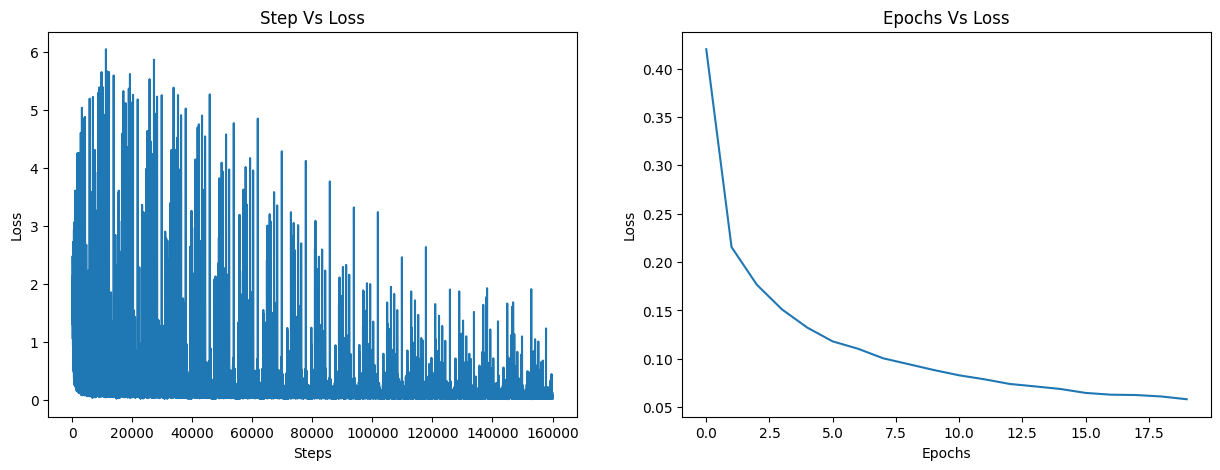

In [28]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(step_losses)
axes[0].set_title("Step Vs Loss")
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[1].plot(epoch_losses)
axes[1].set_title("Epochs Vs Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

In [29]:
model_name = "Deformable_U-Net_8000_v19_L_D_25_epoch.pth"
torch.save(model.state_dict(), model_name)

In [45]:
device = "cpu"
device = torch.device(device)
print(device)

cpu


In [46]:
model_path = "Deformable_U-Net_8000_v19_L_D_25_epoch.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))
model_.eval()

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

In [47]:
test_batch_size = 10
val_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10"
val_label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10"
dataset = WoodscapeDataset(val_dir,val_label_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size,shuffle=True)

In [48]:
import time
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
pred_time_start=time.time()
Y_pred = model_(X)
pred_time_end=time.time()
mean_pred_time=(pred_time_end-pred_time_start)/test_batch_size
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 512, 512])
torch.Size([10, 512, 512])


In [49]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

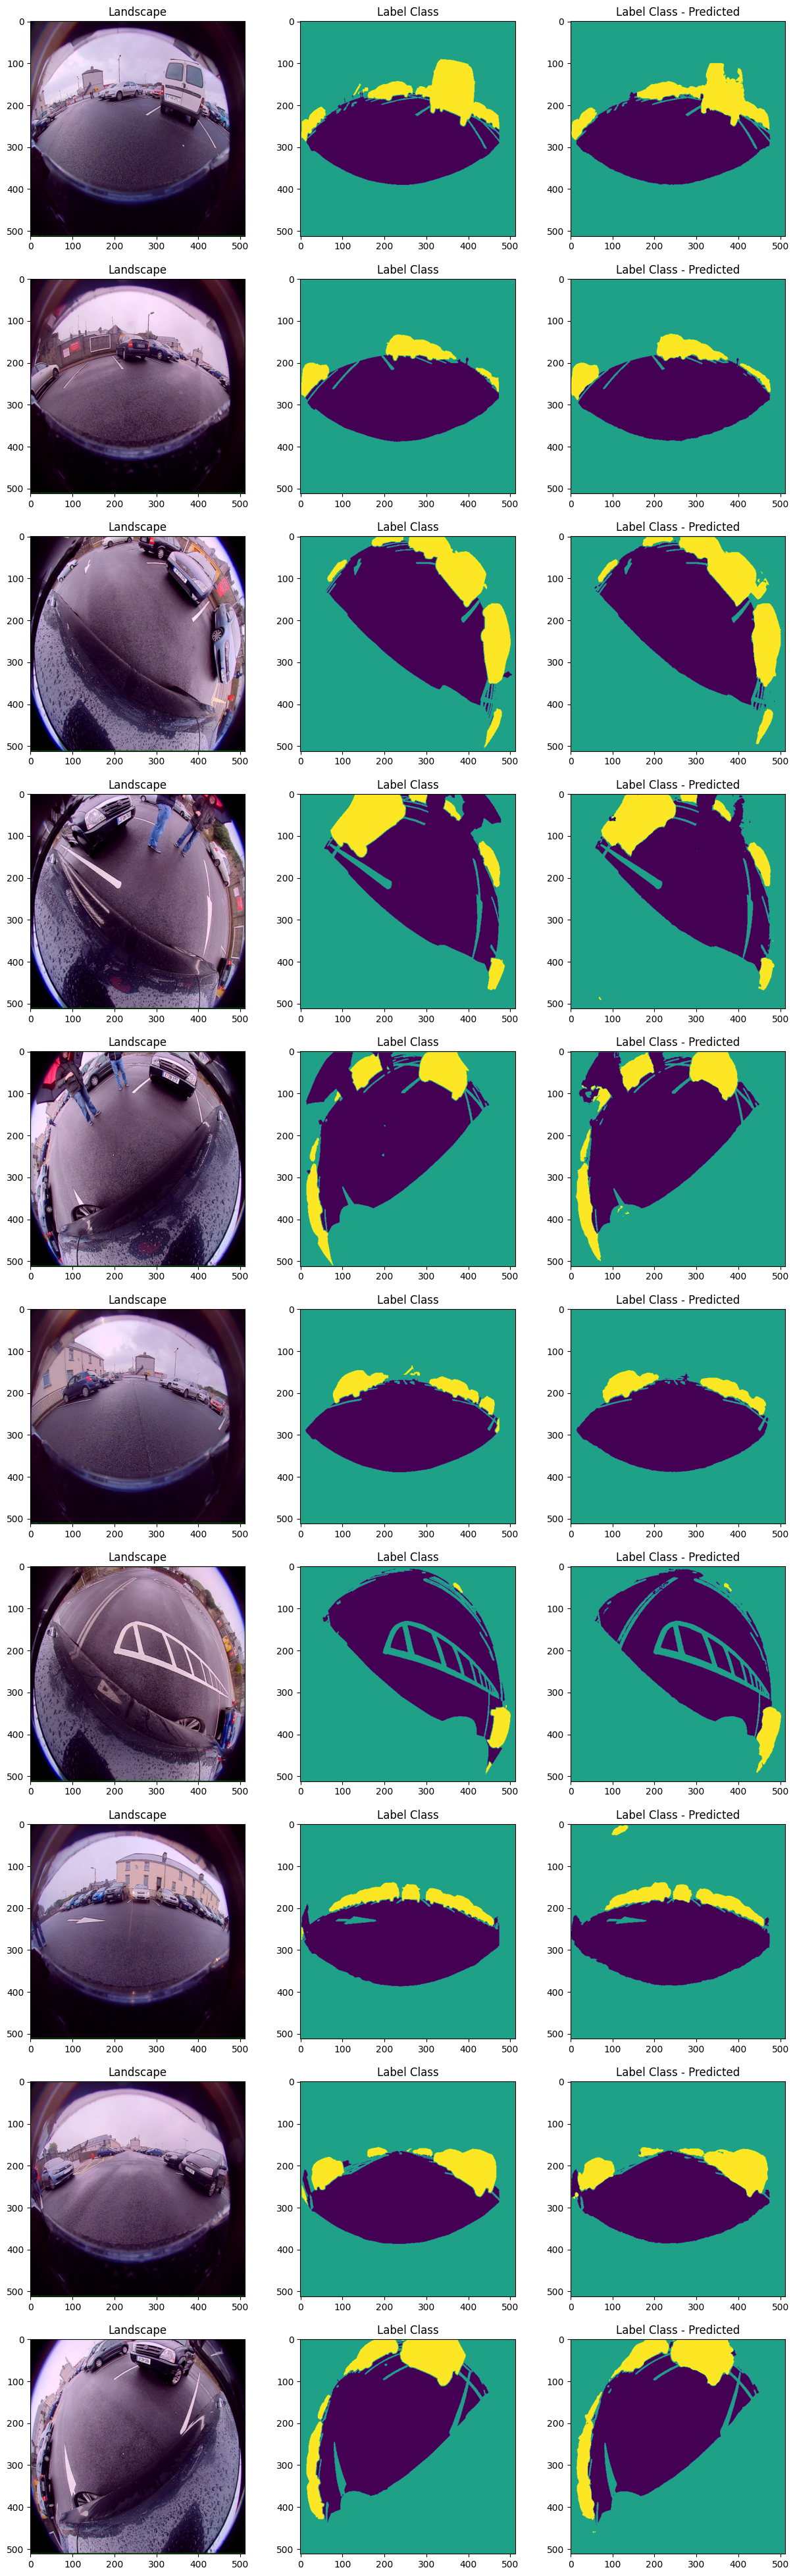

In [70]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [73]:
print("MIOU Score : ",sum(iou_scores) / len(iou_scores))


MIOU Score :  0.8243000000000003


In [74]:
print("Average Prediction Time : ",mean_pred_time)

Average Prediction Time :  20.339281821250914
